In [1]:
from utils import set_root

from loguru import logger

import numpy as np
import torch

from tqdm import tqdm


from captum.attr import IntegratedGradients

from pytorch_lightning import seed_everything

seed_everything(42)
set_root()

Seed set to 42


Current working directory: /home/guido/github/dev/physioex-private


In [2]:
from physioex.data import TimeDistributedModule, SleepEDF
from physioex.train.networks import config as networks

from physioex.train.networks.utils.loss import config as losses

from physioex.explain.spectralgradients import (
    SpectralGradients,
    generate_frequency_bands,
    plot,
)

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [3]:
# load dataset and module
ckpt_path = "models/4b0c2597-61af-439e-b1d6-86de9c36ea3a/fold=0-epoch=14-step=73386-val_acc=0.81.ckpt"
batch_size = 32
sequence_length = 3
model = networks["chambon2018"]

fold = 0
num_workers = 4
picks = ["Fpz-Cz"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = SleepEDF(
    version="2018",
    picks=picks,
    sequence_length=sequence_length,
    target_transform=model["target_transform"],
    preprocessing=model["input_transform"],
)

dataset.split(fold=fold)

dataset = TimeDistributedModule(
    dataset=dataset, batch_size=batch_size, fold=fold, num_workers=num_workers
)

# load model
model["module_config"]["seq_len"] = sequence_length
model["module_config"]["in_channels"] = len(picks)
model["module_config"]["loss_call"] = losses["cel"]
model["module_config"]["loss_params"] = {"params": None}

model = (
    model["module"]
    .load_from_checkpoint(ckpt_path, module_config=model["module_config"])
    .eval()
)


# add a softmax activation function at the end of the model to get probabilities ( care with Seq to Seq )
model = torch.nn.Sequential(model, torch.nn.Softmax(dim=1))

1


In [4]:
# setup the explanations algorithms

model = model.to(device)

sg = SpectralGradients(model)
# ig = IntegratedGradients(model)

Frequency bands: [[0.1, 4.9], [4.9, 9.8], [9.8, 14.7], [14.7, 19.6], [19.6, 24.5], [24.5, 29.4], [29.4, 34.3], [34.3, 39.2], [39.2, 44.1], [44.1, 49.0]]


In [5]:
# get the first batch of the training dataset

train_loader = dataset.train_dataloader()


for inputs, labels in tqdm(train_loader):

    output = model(inputs.to(device)).detach().cpu()

    attr = (
        sg.attribute(inputs.to(device), target=torch.argmax(output, dim=1).to(device))
        .detach()
        .cpu()
    )
    break

attr.shape

  0%|          | 0/4899 [00:00<?, ?it/s]/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|          | 0/4899 [00:02<?, ?it/s]


torch.Size([32, 3, 1, 3000, 10])

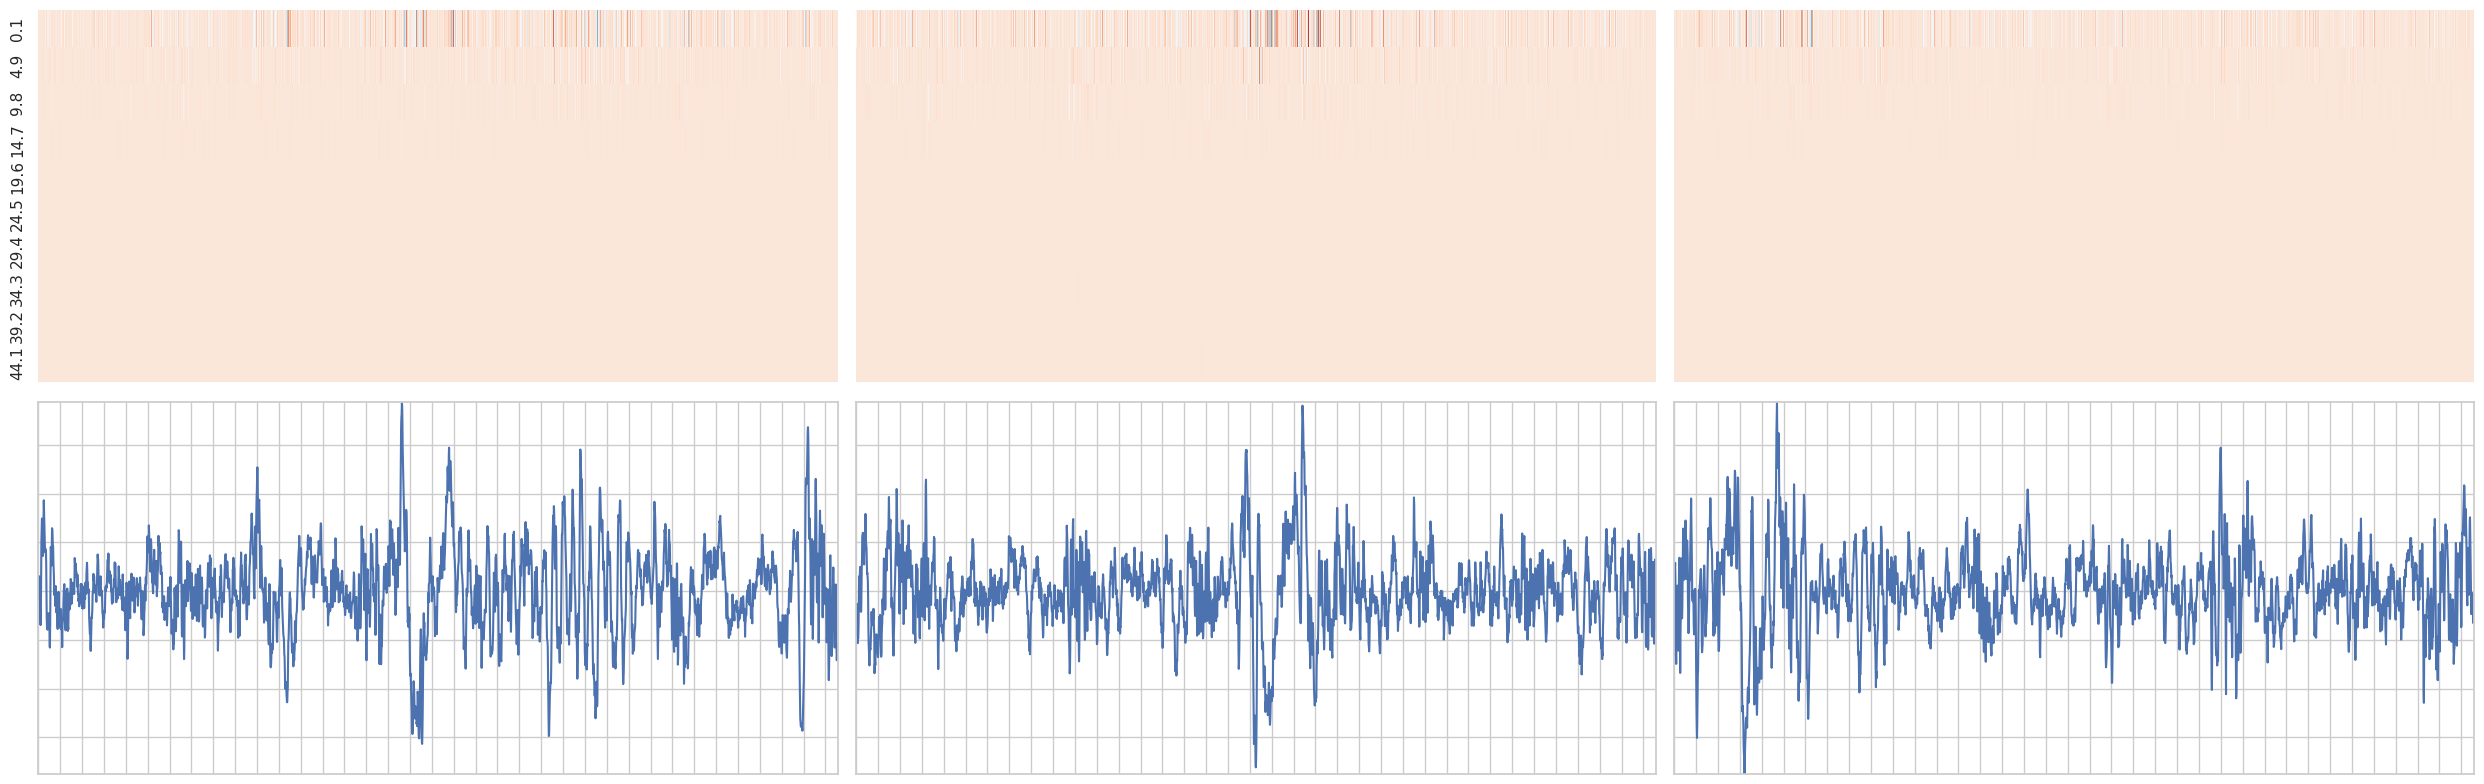

In [6]:
plot(
    input = inputs[0].detach().cpu(),
    attr = attr[0].detach().cpu(),
    bands = sg.bands,
    figsize = (25, 8)
    )

In [ ]:
metric = quantus.Infidelity()

sm = []
for f in range(F):
    spect_metr = metric(
        model,
        inputs.reshape(inputs.size(0), 1, -1).numpy(),
        labels.numpy(),
        device=device,
        explain_func=spect_grad_attr,
        explain_func_kwargs={"filter": f},
    )
    sm.append(spect_metr)


print(f"Spectral gradients metric {spect_metr}")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 63000]